<a href="https://colab.research.google.com/github/dxbee/ml-projects/blob/main/StudentDepressionPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize
!pip install scikit-learn==1.2.2
#!pip install --upgrade scikit-learn xgboost lightgbm scikit-optimize
import pandas as pd
import kagglehub
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from flask import Flask, request, jsonify


# Download latest version
path = kagglehub.dataset_download("hopesb/student-depression-dataset")

print("Path to dataset files:", path)

# List the files in the downloaded dataset directory
print(os.listdir(path))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Path to dataset files: /root/.cache/kagglehub/datasets/hopesb/student-depression-dataset/versions/1
['Student Depression Dataset.csv']


In [2]:
csv_file = os.path.join(path, "Student Depression Dataset.csv")
# Read the dataset into a pandas DataFrame
students = pd.read_csv(csv_file)
students.head(5)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [3]:
# Check for missing values
students.isna().sum()

,0
id,0
Gender,0
Age,0
City,0
Profession,0
Academic Pressure,0
Work Pressure,0
CGPA,0
Study Satisfaction,0
Job Satisfaction,0


In [4]:
# Drop the mmissing columns in 'Financial Stress'
students.dropna(subset=['Financial Stress'], inplace=True)

In [5]:
# Check for missing values
students.isna().sum()

,0
id,0
Gender,0
Age,0
City,0
Profession,0
Academic Pressure,0
Work Pressure,0
CGPA,0
Study Satisfaction,0
Job Satisfaction,0


In [6]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27898 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27898 non-null  int64  
 1   Gender                                 27898 non-null  object 
 2   Age                                    27898 non-null  float64
 3   City                                   27898 non-null  object 
 4   Profession                             27898 non-null  object 
 5   Academic Pressure                      27898 non-null  float64
 6   Work Pressure                          27898 non-null  float64
 7   CGPA                                   27898 non-null  float64
 8   Study Satisfaction                     27898 non-null  float64
 9   Job Satisfaction                       27898 non-null  float64
 10  Sleep Duration                         27898 non-null  object 
 11  Dietary

In [7]:
# Drop 'Work Pressure' and 'Job Satisfaction' as their distributions are skewed
students.drop(columns=['Work Pressure', 'Job Satisfaction'], inplace=True)

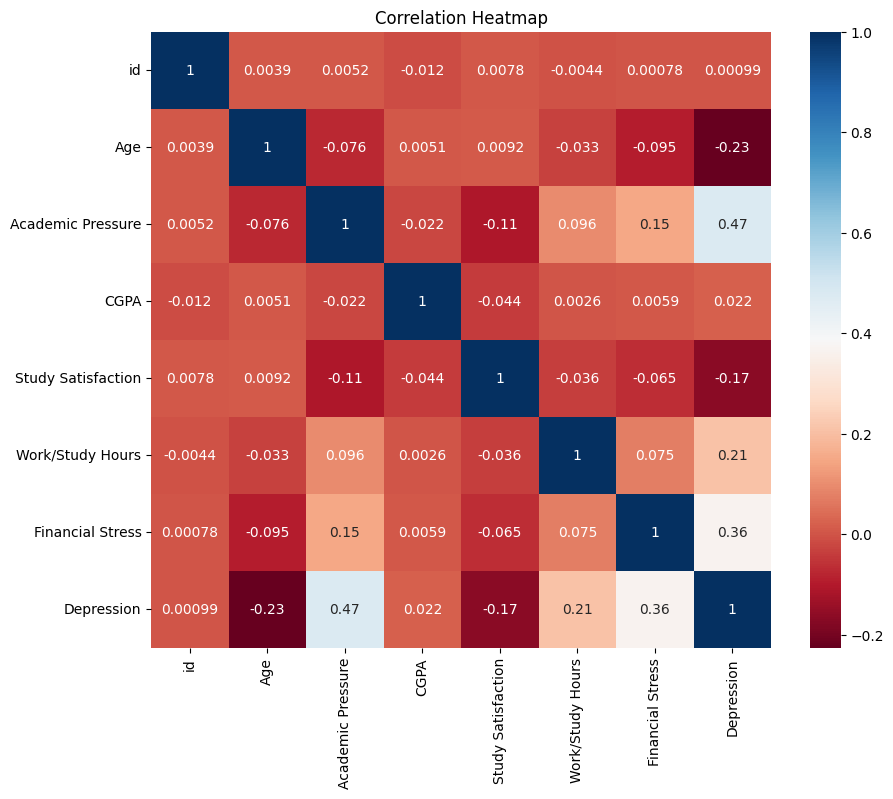

In [8]:
# Select numeric columns
numeric_cols = students.select_dtypes(include=['number'])

# Compute correlation matrix
correlation = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='RdBu')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27898 entries, 0 to 27900
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27898 non-null  int64  
 1   Gender                                 27898 non-null  object 
 2   Age                                    27898 non-null  float64
 3   City                                   27898 non-null  object 
 4   Profession                             27898 non-null  object 
 5   Academic Pressure                      27898 non-null  float64
 6   CGPA                                   27898 non-null  float64
 7   Study Satisfaction                     27898 non-null  float64
 8   Sleep Duration                         27898 non-null  object 
 9   Dietary Habits                         27898 non-null  object 
 10  Degree                                 27898 non-null  object 
 11  Have yo

In [10]:
# Convert boolean values to strings
students[['Gender', 'City', 'Profession',
         'Sleep Duration', 'Dietary Habits',
         'Degree', 'Have you ever had suicidal thoughts ?',
         'Family History of Mental Illness']] = students[['Gender', 'City', 'Profession',
                                                          'Sleep Duration', 'Dietary Habits',
                                                          'Degree', 'Have you ever had suicidal thoughts ?',
                                                          'Family History of Mental Illness']].astype(str)

# One-Hot Encode the categorical features and ensuring binary 0/1 format
ohe = pd.get_dummies(students[['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits',
         'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']],
                     drop_first=True, dtype=int)

# Drop the original categorical columns
students.drop(['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits',
         'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], axis=1, inplace=True)

# Concatenate the encoded columns back to the dataframe
students_df = pd.concat([students, ohe], axis=1)

# View the updated dataframe
students_df.head()

,id,Age,Academic Pressure,CGPA,Study Satisfaction,Work/Study Hours,Financial Stress,Depression,Gender_Male,City_Agra,...,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
0,2,33.0,5.0,8.97,2.0,3.0,1.0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,8,24.0,2.0,5.90,5.0,3.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,26,31.0,3.0,7.03,5.0,9.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,30,28.0,3.0,5.59,2.0,4.0,5.0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,32,25.0,4.0,8.13,3.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
# Define features and target variable
X = students_df.drop(columns=['Depression'])
y = students_df['Depression']

# Shape of features and target
X.shape, y.shape

((27898, 108), (27898,))

In [12]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
# Set up models for Bayesian Optimization
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, tree_method='hist'),
    'LightGBM': LGBMClassifier()
}

# Set up parameters for Bayesian Optimization
param_spaces = {
    'Random Forest': {
        'n_estimators': (10, 200),
        'max_depth': (5, 30),
        'min_samples_split': (2, 10),
    },
    'XGBoost': {
        'n_estimators': (10, 200),
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'subsample': (0.5, 1.0),
    },
    'LightGBM': {
        'n_estimators': (10, 200),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'num_leaves': (20, 50),
    }
}

In [14]:
best_models = {}
best_model_name = None
best_model = None
best_score = 0

# Run Bayesian Optimization for each model
for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=param_spaces[model_name],
        n_iter=30,  # Number of optimization iterations
        scoring='accuracy',
        cv=3,
        random_state=123,
        n_jobs=-1
    )
    optimizer.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {optimizer.best_params_}")
    print(f"Best score for {model_name}: {optimizer.best_score_}")

    best_models[model_name] = optimizer.best_estimator_

    if optimizer.best_score_ > best_score:
        best_model_name = model_name
        best_model = optimizer.best_estimator_
        best_score = optimizer.best_score_

print(f"\nBest model: {best_model_name} with accuracy {best_score}")

Optimizing Random Forest...
Best parameters for Random Forest: OrderedDict([('max_depth', 24), ('min_samples_split', 10), ('n_estimators', 132)])
Best score for Random Forest: 0.8451922590474208
Optimizing XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: OrderedDict([('learning_rate', 0.1279978372936323), ('max_depth', 3), ('n_estimators', 144), ('subsample', 0.5623253572593123)])
Best score for XGBoost: 0.8481046863353603
Optimizing LightGBM...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13065, number of negative: 9253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 22318, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585402 -> initscore=0.344989
[LightGBM] [Info] Start training from score 0.344989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [15]:
# Evaluation of best model
y_pred = best_model.predict(X_test)
print("\nEvaluation of Best Model")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Evaluation of Best Model
Accuracy: 0.8469534050179212
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2310
           1       0.86      0.89      0.87      3270

    accuracy                           0.85      5580
   macro avg       0.84      0.84      0.84      5580
weighted avg       0.85      0.85      0.85      5580



In [16]:
# Save the Best Model
model_filename = f"best_model_{best_model_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"Best model saved as {model_filename}")

Best model saved as best_model_XGBoost.pkl


In [27]:
# Save training feature names alongside the model
training_features_filename = "training_features.pkl"
joblib.dump(list(X_train.columns), training_features_filename)
print(f"Feature names saved as {training_features_filename}")

Feature names saved as training_features.pkl
